In [78]:
import pandas as pd

In [79]:
df = pd.read_csv("task1_data.txt")
train_labels = pd.read_csv("task1_train_label.txt", header=None, sep="\t", names=["order", "return"])
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "return"])
test_query = pd.read_csv("task1_test_query.txt",header=None, names=["order"])

In [80]:
train_df = df.merge(train_labels, on="order")
valid_df = df.merge(valid_labels, on="order")
test_df = df.merge(test_query, on="order")

In [81]:
train_df["return"].value_counts(dropna=False)

return
1    1116464
0     431381
2     345549
Name: count, dtype: int64

In [82]:
train_df

,order,product,customer,color,size,group,return
0,298957,54654,192219,169,10,11,0
1,298957,57127,192219,611,10,11,0
2,570617,23677,322757,43,24,19,1
3,570617,54993,322757,543,24,19,1
4,654410,53969,305375,313,17,27,2
...,...,...,...,...,...,...,...
1893389,304137,7155,239280,310,14,8,1
1893390,304137,28930,239280,291,2,23,1
1893391,359783,477,299845,131,14,1,2
1893392,117952,26468,81215,192,24,8,2


<Axes: >

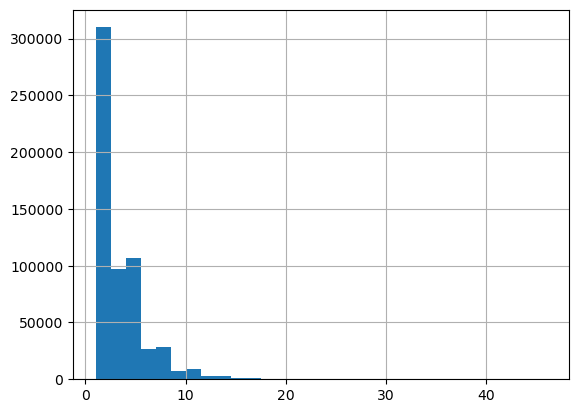

In [83]:
train_df.groupby("order").size().hist(bins=30)

In [84]:
train_df['product'].value_counts()

product
48216    1984
27066    1671
44701    1509
6982     1207
28512    1102
         ... 
31260       1
9554        1
35543       1
2941        1
3298        1
Name: count, Length: 58415, dtype: int64

In [85]:
train_df

,order,product,customer,color,size,group,return
0,298957,54654,192219,169,10,11,0
1,298957,57127,192219,611,10,11,0
2,570617,23677,322757,43,24,19,1
3,570617,54993,322757,543,24,19,1
4,654410,53969,305375,313,17,27,2
...,...,...,...,...,...,...,...
1893389,304137,7155,239280,310,14,8,1
1893390,304137,28930,239280,291,2,23,1
1893391,359783,477,299845,131,14,1,2
1893392,117952,26468,81215,192,24,8,2


# Baseline

<Axes: >

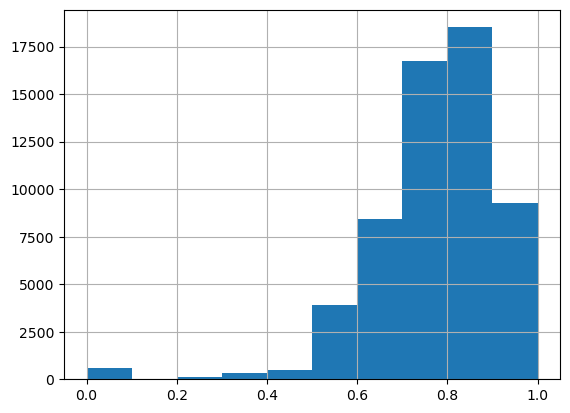

In [86]:
# Calculate how many times each product has been in an order that was returned/partially returned
# Return probability is the ratio of returns/partial returns and all occurences of the product
product_stats = train_df.groupby('product').agg(
    total_count=('product', 'count'),
    return_1_or_2_count=('return', lambda x: (x==1).sum() + (x==2).sum())
).reset_index(drop=True)
product_stats['return_rate'] = product_stats['return_1_or_2_count'] / product_stats['total_count']
product_stats["return_rate"].hist()

In [87]:
valid_df = valid_df.merge(product_stats["return_rate"], how='left', right_index=True, left_on='product')
valid_df["no_return_rate"] = 1 - valid_df["return_rate"]

,order,product,customer,color,size,group,return
0,529565,10260,212452,92,17,19,0
1,529565,51789,212452,169,17,19,0
2,529565,12020,212452,313,17,19,0
3,529565,17961,212452,627,10,19,0
4,529565,47772,212452,409,17,6,0
...,...,...,...,...,...,...,...
386801,649891,29753,106325,81,17,0,2
386802,735831,3463,37468,249,14,9,0
386803,435829,21960,270329,31,10,11,0
386804,435829,58150,270329,548,17,11,0


<Axes: >

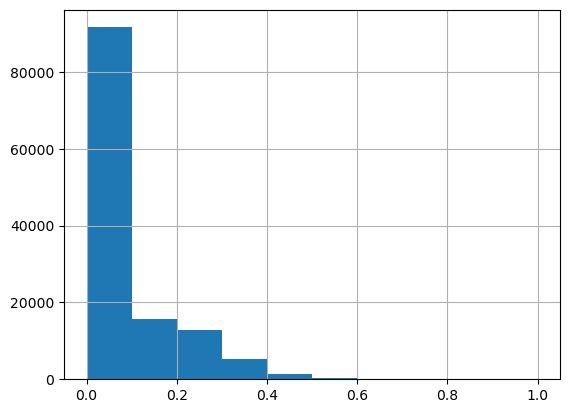

In [88]:
# Probability of a full return is the product of the return rates of all products in the order
# Probablity of no return is the product of the no return rates of all products in the order
order_return_rate = valid_df.groupby('order')['return_rate'].prod()
order_no_return_rate = valid_df.groupby('order')['no_return_rate'].prod()
order_no_return_rate.hist()

In [89]:
# Probability of partial return is 1 - (probability of no return + probability of full return)
return_df = pd.concat([order_return_rate, order_no_return_rate], axis=1, keys=['order_return_rate', 'order_no_return_rate'])
return_df["some_return"] = 1 - return_df["order_no_return_rate"] - return_df["order_return_rate"]
return_df

In [92]:
filtered_df = return_df[(return_df['order_no_return_rate'] > return_df['order_return_rate']) & (return_df['order_no_return_rate'] > return_df['some_return'])]

In [93]:
import numpy as np

# Prediction is the highest of the three probabilities
conditions = [
    (return_df['order_no_return_rate'] > return_df['some_return']) & (return_df['order_no_return_rate'] > return_df['order_return_rate']),
    (return_df['some_return'] > return_df['order_no_return_rate']) & (return_df['some_return'] > return_df['order_return_rate']),
    (return_df['order_return_rate'] > return_df['order_no_return_rate']) & (return_df['order_return_rate'] > return_df['some_return'])
]

choices = [0, 1, 2]

return_df['prediction'] = np.select(conditions, choices, default=np.nan)

In [95]:
# Accuracy calculation
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "label"])
return_df = return_df.merge(valid_labels, on="order")
return_df["correct"] = return_df["prediction"] == return_df["label"]
accuracy = return_df["correct"].sum() / return_df["correct"].count()